In [1]:
import cvxpy as cvx
import ipopt
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
%matplotlib inline

## DCP with CVXPy

Model problem is [compressed sensing](https://www.raeng.org.uk/publications/other/candes-presentation-frontiers-of-engineering)
\begin{align*}
& \min_x \|x\|_1\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

### Data generation

In [2]:
n = 1000
m = 10
x_true = np.random.randn(n)
x_true[np.abs(x_true) > 0.05] = 0
print("Num of nnz in x = {}".format(np.sum(x_true != 0)))
A = np.random.randn(m, n)
b = A.dot(x_true)

Num of nnz in x = 47


### [CVXPy](http://www.cvxpy.org/index.html) 

In [3]:
x = cvx.Variable(n)
objective = cvx.norm1(x)
constr = [A*x == b]
problem = cvx.Problem(cvx.Minimize(objective), constr) 
problem.solve(verbose=True, max_iter=3000)

-----------------------------------------------------------------
           OSQP v0.4.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 2000, constraints m = 2010
          nnz(P) + nnz(A) = 14000
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 3000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -8.0000e+03   8.00e+00   5.31e+01   1.00e-01   3.31e-03s
 200   1.7620e-01   9.19e-05   2.52e-02   2.40e+01   1.79e-02s
 400   1.7107e-01   2.56e-04   1.95e-03   3.58e+00   3.35e-

0.17106554403525423

### Check solution

In [6]:
tol= 1e-4
print(np.linalg.norm(A.dot(x.value) - b))
print(np.linalg.norm(A[:, np.abs(x.value) > tol].dot(x.value[np.abs(x.value) > tol]) - b))
print(np.linalg.norm(x_true - x.value))
print("Num nnz = {}".format(np.sum(np.abs(x.value) > tol)))

3.947753868209626e-07
0.03654345066898236
0.18526781206793796
Num nnz = 69


(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 <a list of 7 Text yticklabel objects>)

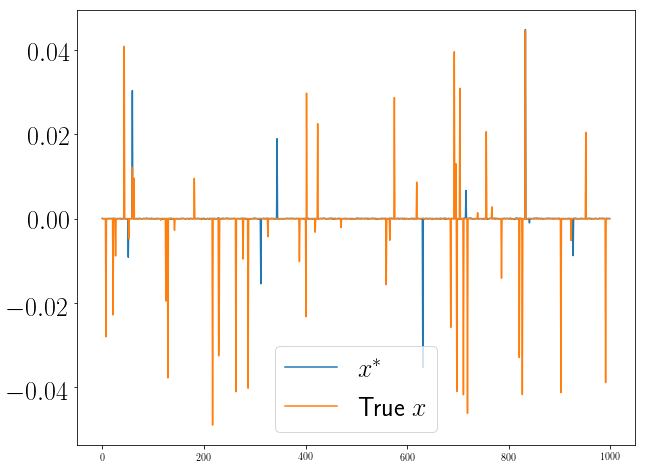

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(x.value, label=r"$x^*$")
plt.plot(x_true, label=r"True $x$")
plt.legend(fontsize=26)
plt.yticks(fontsize=26)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text xticklabel objects>)

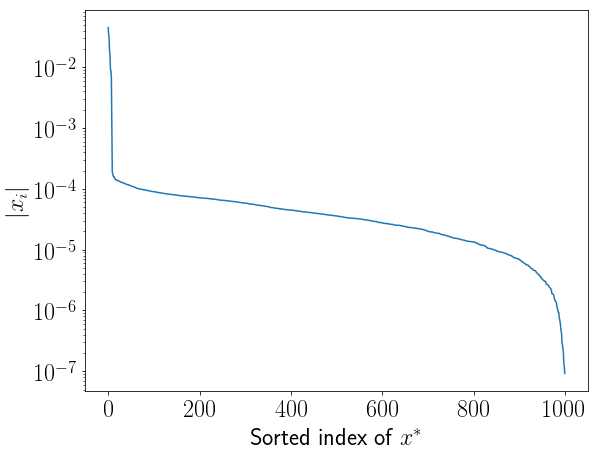

In [8]:
plt.figure(figsize=(9, 7))
plt.semilogy(np.sort(np.abs(x.value))[::-1])
plt.ylabel("$|x_i|$", fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r"Sorted index of $x^*$", fontsize=24)
plt.xticks(fontsize=24)

### Check DCP

In [9]:
# Non-affine equality constraint
y = cvx.Variable(1)
obj = cvx.Minimize(cvx.power(y, 3))
problem = cvx.Problem(obj, [cvx.power(y - 3, 2) == 0])
problem.solve(verbose=True)

DCPError: Problem does not follow DCP rules.

In [10]:
# Non-convex objective function 
y = cvx.Variable(2)
obj = cvx.Minimize(y[0]**2 - y[1]**2)
problem = cvx.Problem(obj)
problem.solve(verbose=True)

DCPError: Problem does not follow DCP rules.

## General purpose IPOPT

#### Smooth problem similar to the problem in part 1

\begin{align*}
& \min_x \|x\|^2_2\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

In [11]:
f = lambda x: np.linalg.norm(x, 2)**2
constr = {"fun": lambda x: A.dot(x) - b, 
          "jac": lambda x: A,
          "type": "eq"}
res = ipopt.minimize_ipopt(f, jac=lambda x: 2 * x, x0=np.zeros(n), constraints=constr)

In [12]:
print(np.linalg.norm(A.dot(res.info["x"]) - b))
res.info["status_msg"]

3.876020188811474e-16


b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'

#### Non-smooth problem from part 1

\begin{align*}
& \min_x \|x\|_1\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

In [13]:
f = lambda x: np.linalg.norm(x, 1)
constr = {"fun": lambda x: A.dot(x) - b, 
          "jac": lambda x: A,
          "type": "eq"}
res = ipopt.minimize_ipopt(f, jac=lambda x: np.sign(x), x0=np.zeros(n), constraints=constr)

In [14]:
print(np.linalg.norm(A.dot(res.info["x"]) - b))
res.info["status_msg"]

1.0700586606578977e-16


b"Restoration phase failed, algorithm doesn't know how to proceed."